<a href="https://colab.research.google.com/github/jaxckle/Insprit_AI_2025_Learning/blob/main/Jaxon_Student_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="red"><h1><b><u>MAKE A COPY OF THIS NOTEBOOK SO YOUR EDITS ARE SAVED</u></b></h1></font>

---
---
<h1>🐶<b><i> Convolutional Neural Networks: Improving Our Self-Driving Car's Performance</i></b></h1>


Welcome back to CC: Conscientious Cars! Today, we'll be improving on our system for distinguishing dogs from roads.

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown ##**BEFORE RUNNING ANY CODE, please change your Hardware Accelerator to GPU to train faster!**</h2>
#@markdown 1. Click on the **Runtime** menu at the top of the screen.
#@markdown 2. Click **Change Runtime Type**.
#@markdown 3. Choose **T4 GPU** under **Hardware Accelerator**.

#@markdown Once you've done that, run this code cell to check you're correctly connected!

import tensorflow as tf
from IPython.display import Markdown

if tf.test.gpu_device_name():
  display(Markdown("###✅ GPU connected!"))
else:
  display(Markdown("""
###❌ No GPU found!
If you're running into GPU limits when you try to switch, here are some suggestions:
  - Wait 12-24 hours for the limits to reset.
  - Share your copy of the notebook with another Google account that hasn't met the limit, and work through the notebook with that account.
  - Look into a paid subscription or paying for compute units as you go.
  """))

###✅ GPU connected!

In [ ]:
#@title **🏗 Setup Cell** {"display-mode":"form", "form-width":"25%"}
#@markdown **Run this to import libraries and download data!**

#-------------------------------------------------------------------------------
# IMPORTS
#-------------------------------------------------------------------------------
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, InputLayer
from tensorflow.keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from tensorflow.keras.utils import to_categorical

# Inspirit's util file and discussion exercise answer handler
if not os.path.exists('inspiritai_util.py'):
    !wget -q "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Modules/inspiritai_util.py"
from inspiritai_util import handle_discussion_response


#-------------------------------------------------------------------------------
# HELPER FUNCTIONS
#-------------------------------------------------------------------------------
def categorical_to_numpy(labels_in):
  labels = []
  for label in labels_in:
    if label == 'dog':
      labels.append(np.array([1, 0]))
    else:
      labels.append(np.array([0, 1]))
  return np.array(labels)

def one_hot_encoding(input):
  output = np.zeros((input.size, input.max()+1))
  output[np.arange(input.size), input] = 1

  return output

def load_data():
  # Run this cell to download our data into a file called 'cifar_data'
  !wget -q --show-progress -O cifar_data https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%204%20_%205%20-%20Neural%20Networks%20_%20CNN/dogs_v_roads

  # now load the data from our cloud computer
  import pickle
  with open("cifar_data", "rb") as f:
      data_dict = pickle.load(f)

  data   = data_dict['data']
  labels = data_dict['labels']

  return data, labels

def plot_one_image(data, labels, img_idx):
  import matplotlib.pyplot as plt

  img   = data[img_idx, :].reshape([32,32,3]).copy()
  label = labels[img_idx]

  fig, ax = plt.subplots(1,1)
  img = ax.imshow(img.astype('uint8'), extent=[-1,1,-1,1])

  x_label_list = [0, 8, 16, 24, 32]
  y_label_list = [0, 8, 16, 24, 32]

  ax.set_xticks([-1, -0.5, 0, 0.5, 1])
  ax.set_yticks([-1, -0.5, 0, 0.5, 1])

  ax.set_xticklabels(x_label_list)
  ax.set_yticklabels(y_label_list)

  ax.set_title(f'Image: {img_idx} | Label: {label}')

  display(fig)
  plt.close(fig)

def plot_acc(history, ax=None, xlabel='Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 'best')
    ax.set_ylim([0.4, 1.005])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

def logits_to_one_hot_encoding(input):
    """
    Converts softmax output (logits) to a one-hot encoded format.

    This function takes an array of softmax output probabilities
    (usually from a neural network's output layer) and converts
    each row to a one-hot encoded vector. The highest probability
    in each row is marked as 1, with all other values set to 0.

    Parameters:
    input (numpy.ndarray): A 2D array where each row contains softmax probabilities for each class.
                            The shape of the array is (n_samples, n_classes).

    Returns:
    numpy.ndarray: A 2D array of the same shape as the input, where each row is the one-hot encoded representation
                   of the class with the highest probability in the original row.
    """

    output = np.zeros_like(input, dtype=int)
    output[np.arange(len(input)), np.argmax(input, axis=1)] = 1
    return output

#-------------------------------------------------------------------------------
# CUSTOM CNN CLASS
#-------------------------------------------------------------------------------
class CNNClassifier:
    """
    A Convolutional Neural Network (CNN) classifier using Keras, customized for binary classification tasks.

    This class wraps a Keras Sequential model with a specific architecture suitable for image classification tasks.
    It includes a custom `predict` method that outputs one-hot encoded predictions, and other standard Keras model
    methods are accessible as well. This was done to override the need for the SciKeras wrappers that is frequently
    incompatible with Google Colab versions of Keras & Tensorflow. Feel free to modify as needed.

    Attributes:
        num_epochs (int): The number of training epochs.
        layers (int): The number of convolutional layers in the model.
        dropout (float): The dropout rate used in dropout layers for regularization.
        model (keras.models.Sequential): The underlying Keras Sequential model.

    Methods:
        build_model(): Constructs the CNN model with the specified architecture and compiles it.

        fit(*args, **kwargs): Trains the model. Accepts arguments compatible with the Keras `fit` method.

        predict(*args, **kwargs): Predicts labels for the input data. Converts the softmax output of the model
                                  to one-hot encoded format using `logits_to_one_hot_encoding`. Necessary to match
                                  accuracy_score function expected arguments.

        predict_proba(*args, **kwargs): Predicts labels for the input data and returns the raw output of the softmax.
                                        Used when wanting to inspect the raw probabilistic scoring of the model.

    Usage:
        cnn_classifier = CNNClassifier(num_epochs=30, layers=4, dropout=0.5)
        cnn_classifier.fit(X_train, y_train)
        predictions = cnn_classifier.predict(X_test)

    Note:
        The `__getattr__` method is overridden to delegate attribute access to the underlying Keras model,
        except for the `predict` method which is customized.
    """
    def __init__(self, num_epochs=30, layers=4, dropout=0.5):
        self.num_epochs = num_epochs
        self.layers = layers
        self.dropout = dropout
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Reshape((32, 32, 3)))

        for i in range(self.layers):
          model.add(Conv2D(32, (3, 3), padding='same'))
          model.add(Activation('relu'))

        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(self.dropout))

        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(self.dropout))

        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dropout(self.dropout))
        model.add(Dense(2))
        model.add(Activation('softmax'))
        opt = keras.optimizers.RMSprop(learning_rate=0.0001)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

        return model

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, epochs=self.num_epochs, batch_size=10, verbose=2, **kwargs)

    # NOTE: WRITTEN TO RETURN ONE HOT ENCODINGS FOR ACCURACY
    def predict(self, *args, **kwargs):
        predictions = self.model.predict(*args, **kwargs)
        return logits_to_one_hot_encoding(predictions)

    def predict_proba(self, *args, **kwargs):
        predictions = self.model.predict(*args, **kwargs)
        return predictions

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

    def __getattr__(self, name):
        if name != 'predict' and name != 'predict_proba':
            return getattr(self.model, name)
        else:
            raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")

<font color=red size="5"><b> ⬆ Click the play button before moving on! </b></font>

## Table of Contents

You can find a more detailed Table of Contents by clicking on the icon on the left sidebar that looks like this: <img src="https://drive.google.com/uc?export=view&id=1AGUz4POrRWu_6n5yI_YdO4qFRr41_PzE" width=20>.

>[📊 Milestone 1: Review of the Dataset](#scrollTo=1QxGsnvhnn8R)

>[🖼️ Milestone 2: CNNClassifier](#scrollTo=37O_VE_D1Bdy)

>>[Training and Validation Curves](#scrollTo=c-XRh5Y5P_CL)

>[🔨 Milestone 3: Building Neural Networks from Scratch in Keras](#scrollTo=76z4NAY6afd7)

>[🏗 Milestone 4: Building a CNN Using Keras!](#scrollTo=QCbD6siv-Ip-)

>>[Optional Reference: Understanding Hyperparameters in CNNs](#scrollTo=f5Vi6h06HZXZ)

>[(Optional Challenge) 🐈 Milestone 5: Cats vs. Dogs with CNN](#scrollTo=z6BekoxKVq0G)

>>[Advanced Challenge: Implementing a Famous Architecture for Cats vs. Dogs](#scrollTo=m6sFSGEqjPwe)

>>[From AlexNet to VGGNet: A Better Choice for Image Classification](#scrollTo=ePRiJhGdEgQL)

>[🤔 Knowledge Check](#scrollTo=JY2JwKkIVe53)


>[📋 Cheat Sheets](#scrollTo=zreklStpVNcW)



---
---
# **📊 Milestone 1: Review of the Dataset**

Once again, let's load in our dog/road dataset and create our training and test set. **What's the shape of each dataset? Why?**

In [ ]:
# Load our data
data_raw, labels_raw = load_data()
data = data_raw.astype(float)
labels = categorical_to_numpy(labels_raw)
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.2, random_state=1)

### WRITE YOUR CODE BELOW: Print the image data and its shape using the shape attribute!
data.shape



cifar_data          100%[===================>]   3.52M  --.-KB/s    in 0.03s   


(1200, 3072)

Use the cell below as a reminder of what the data looks like.

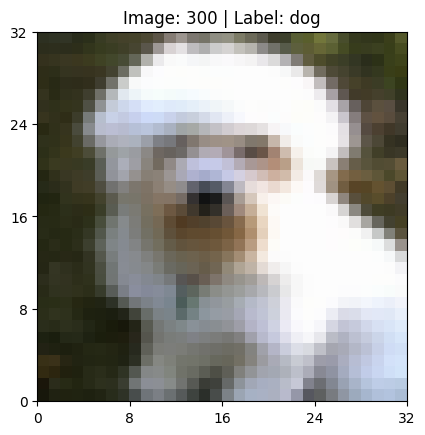

In [ ]:
plot_one_image(data_raw, labels_raw, 300) # Play around with the number!

---
---
# **🖼️ Milestone 2: CNNClassifier**

> Note: This section goes over the CNNClassifier covered at the end of the neural networks notebook in more depth, including exploring hyperparameters!

> While this section is a good warm-up for the more complex code later, you can feel free to go through this quickly to have more time to build custom neural networks, especially since hyperparameters are also covered in more depth later. Make sure you understand the training and validation curves before moving to other milestones though!

### 2.1.1. Coding Exercise

As you know, there is a famous type of neural network known as convolutional neural networks (CNNs). These types of neural networks work particularly well on problems to do with computer vision. Let's try one out!

To load up a simple CNN, just run the following! The `CNNClassifier` is a custom class we've built for you that mimics the behavior of the scikit-learn models you're used to. Feel free to check out the set-up cell to see how it's built, especially after you've finished up building your Keras models later in the notebook!

```python
cnn = CNNClassifier(num_epochs, layers, dropout)
```

Here are some quick descriptions of each parameter; try to figure out how each might affect the model's performance!

- **`num_epochs`**: the number of times we allow our model to train on the entire training dataset
- **`layers`**: the number of convolutional layers we'd like to add to our model
- **`dropout`**: the probability a given neuron's weight in a given layer is set to 0 during training.


**Try different values of num_epochs, layers, and dropout so that you get the best possible accuracy on the test set!**

*Tip*: You can use `model.score()` to find that accuracy, as we do below. This method allows us to give all the test data to the model for it to determine the accuracy score, thereby saving us the trouble of saving the predictions and calculating the score ourselves!

In [ ]:
# Create and train our CNN model
import random
num_epochs=22
layers=8
cnn = CNNClassifier(num_epochs, layers, dropout=0.3)
cnn.fit(X_train, y_train)

# Print the score on the testing data
print(cnn.score(X_test, y_test))


Epoch 1/22
96/96 - 10s - 101ms/step - accuracy: 0.7448 - loss: 0.5795
Epoch 2/22
96/96 - 1s - 6ms/step - accuracy: 0.8792 - loss: 0.2658
Epoch 3/22
96/96 - 1s - 6ms/step - accuracy: 0.9177 - loss: 0.2287
Epoch 4/22
96/96 - 1s - 6ms/step - accuracy: 0.9271 - loss: 0.1907
Epoch 5/22
96/96 - 1s - 6ms/step - accuracy: 0.9333 - loss: 0.1828
Epoch 6/22
96/96 - 0s - 4ms/step - accuracy: 0.9365 - loss: 0.1612
Epoch 7/22
96/96 - 1s - 7ms/step - accuracy: 0.9490 - loss: 0.1291
Epoch 8/22
96/96 - 1s - 6ms/step - accuracy: 0.9469 - loss: 0.1409
Epoch 9/22
96/96 - 1s - 7ms/step - accuracy: 0.9594 - loss: 0.1169
Epoch 10/22
96/96 - 1s - 6ms/step - accuracy: 0.9698 - loss: 0.1041
Epoch 11/22
96/96 - 0s - 5ms/step - accuracy: 0.9563 - loss: 0.1161
Epoch 12/22
96/96 - 1s - 6ms/step - accuracy: 0.9698 - loss: 0.0985
Epoch 13/22
96/96 - 0s - 4ms/step - accuracy: 0.9729 - loss: 0.0810
Epoch 14/22
96/96 - 1s - 6ms/step - accuracy: 0.9729 - loss: 0.0799
Epoch 15/22
96/96 - 1s - 6ms/step - accuracy: 0.9760 -

**How well did your neural network perform?**

CNNs typically perform better than fully-connected neural networks on vision problems, but, as before, they aren't always consistent. They are also sensitive to a number of parameters.

## Training and Validation Curves

An important aspect of training neural networks is to prevent overfitting. **How would we recognize overfitting?**

In the first line of code below, we first **fit** the model on the training data and pass in some validation (or test) data to evaluate it. We call it the **history** because we want to retain information about the accuracy at each epoch.

In the second line we plot the history so that we can compare the training and validation accuracies.  

```python
history = model.fit(X_train, y_train, validation_data=(X_test, y_test))
plot_acc(history)
```

### 2.1.2. Coding Exercise

**After how many epochs does the model begin to overfit? How does this vary as you vary the number of hidden layers and dropout?** Overfitting occurs when the validation accuracy starts to drop below the training accuracy.

Epoch 1/15
96/96 - 8s - 82ms/step - accuracy: 0.6698 - loss: 0.5932 - val_accuracy: 0.7625 - val_loss: 0.4807
Epoch 2/15
96/96 - 2s - 16ms/step - accuracy: 0.8438 - loss: 0.3716 - val_accuracy: 0.8500 - val_loss: 0.3262
Epoch 3/15
96/96 - 1s - 8ms/step - accuracy: 0.8927 - loss: 0.2898 - val_accuracy: 0.9417 - val_loss: 0.2265
Epoch 4/15
96/96 - 1s - 12ms/step - accuracy: 0.9104 - loss: 0.2367 - val_accuracy: 0.9542 - val_loss: 0.1791
Epoch 5/15
96/96 - 1s - 7ms/step - accuracy: 0.9198 - loss: 0.2037 - val_accuracy: 0.9417 - val_loss: 0.2329
Epoch 6/15
96/96 - 1s - 7ms/step - accuracy: 0.9240 - loss: 0.1953 - val_accuracy: 0.9375 - val_loss: 0.1871
Epoch 7/15
96/96 - 1s - 12ms/step - accuracy: 0.9396 - loss: 0.1752 - val_accuracy: 0.9583 - val_loss: 0.1593
Epoch 8/15
96/96 - 1s - 6ms/step - accuracy: 0.9427 - loss: 0.1563 - val_accuracy: 0.9333 - val_loss: 0.2065
Epoch 9/15
96/96 - 1s - 7ms/step - accuracy: 0.9406 - loss: 0.1500 - val_accuracy: 0.9417 - val_loss: 0.1845
Epoch 10/15
96/

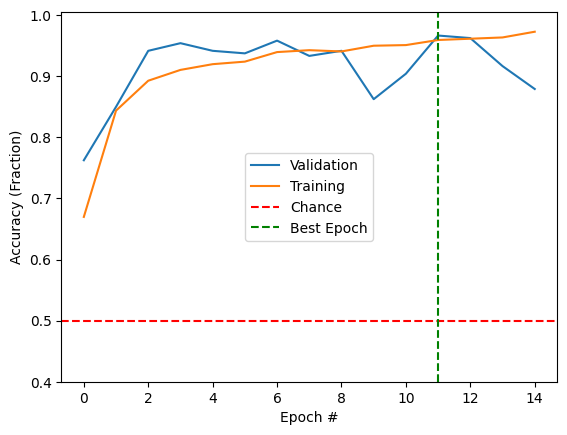

In [ ]:
### WRITE YOUR CODE BELOW

cnn=CNNClassifier(num_epochs=15,layers=12,dropout=0.5)

history = cnn.fit(X_train, y_train, validation_data=(X_test,y_test))
plot_acc(history)

In [ ]:
# Print the score on the testing data
print("CNN Testing Set Score:")
print(cnn.score(X_test, y_test))

CNN Testing Set Score:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
0.8791666666666667


---
---
# **🔨 Milestone 3: Building Neural Networks from Scratch in Keras**

So far, we've used our helper class which pre-builds a Keras neural network model. Now, we can build them on our own!

Let's start with a "toy example": a tiny neural network with just three numerical inputs.


### 3.1.1. Coding Exercise



We're going to build this simple model:

<center>
<img src="http://cs231n.github.io/assets/nn1/neural_net.jpeg">
</center>

This network can be described as:
* Input Layer: 3 neurons
* Layer 1 (Hidden): 4 neurons that are activated by `'relu'`
* Layer 2 (Output): 2 neurons that are activated by `'softmax'`


We also want to compile the model with
`loss = 'categorical_crossentropy'`

What does this represent? Here's one way to interpret it:
* This model classifies animals as "cat" or "dog"
* Our three inputs are height, weight, and age
* Our outputs represent "probability of cat" and "probability of dog"
* Because this is a toy example, we aren't actually training the model here - just using randomly initialized weights! We will train later models in this notebook.

Try looking at the template code below! Uncomment one line at a time and fill in each blank, and make sure you understand which line goes with which part of the above structure. **If you want a hint or more details, check out the optional reference below.**


In [ ]:
### WRITE YOUR CODE BELOW: delete the #s and fill in the blanks!

model_1 = Sequential()
model_1.add(InputLayer(shape=(3,)))
model_1.add(Dense(4, activation='relu')) #the 0 neg function
model_1.add(Dense(2, activation='softmax'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.predict(np.array([[14, 18, 5]])) # Try any input! This represents an animal of height 14, weight 18, and age 5.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


array([[0.96443576, 0.03556425]], dtype=float32)

### 3.1.2. Discussion Exercise

In [ ]:
#@markdown *How would you interpret this output? Does our (untrained) network classify this as a cat or a dog?*
answer = "" # @param {"type":"string"}
handle_discussion_response(answer)

Please input your response in the answer box above!


### *(Optional) Reference: Basic Keras Sequential Models*
> Take a look at this section if you want more information on how a Keras Sequential model is built!



Here's some information about each step of the process. **You don't need to read through all this - check it as a reference if needed!**

#### **1. Specify model**

```python
model = Sequential()
```

In this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION sequentially as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it.


#### **2. Add layers to the network**
```python
model.add(InputLayer(shape=(5,)))
```

In this code, we add the input layer to the model. Here, we specify that there is a 1-dimensional list of 5 values as input.

```python
model.add(Dense(4, activation='sigmoid'))
```

In this code, we add a layer of 4 neurons to our network. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layer's outputs.

We also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use `'softmax'` or `'sigmoid'`. If you want the neuron to output any number, you can use `'linear'`! You'll also often see `'relu'`, which is when a neuron will only output nonnegative numbers.

```python
model.add(Dense(1, activation='linear'))
```

This code would add ANOTHER layer to the network that has 1 neuron. Since this would be our last layer in this example, this one neuron is used to predict a continuous value!

#### **3. Turn the model on by compiling it**

After having built the network, we want to train and use it, so we have to 'compile' it to prepare. We have to specify at the very least: a loss (how the model measures the quality of its weights), an optimizer (which adjusts the weights), and a metric (how to evaluate our results). Here are some common choices:

```python
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])
```

Once we've created our network, we can use it very simply! Just like we did with sklearn, we define our input data (`X`), the true predictions from that data (`y`), and then train our model with `fit`.

```
model.fit(X, y)
```

To use the model, you can use it to predict something with:

```
y_pred = model.predict(X)
```

You can actually use the model before you even train it! It just won't perform very well.

### *(Optional) Reference: Neural Network Math: ReLU vs. Softmax*
> This section delves a bit more into the math behind some of the activation functions from above.


As you've seen already two commonly used activation functions are ReLU (Rectified Linear Unit) and Softmax, each serving distinct purposes in neural networks.

#### **ReLU (Rectified Linear Unit)**
- **Usage**: ReLU is primarily used in the hidden layers of neural networks.
- **Function**: It outputs the input directly if it is positive; otherwise, it will output zero. Mathematically, it's defined as

$$ f(x) = \max(0, x) $$

- **Advantages**:
  - Helps in speeding up the training process by overcoming the vanishing gradient problem common with other activation functions like sigmoid or tanh.
  - It introduces non-linearity into the network, allowing it to learn more complex patterns.

#### **Softmax**
- **Usage**: Softmax is typically used in the output layer of a classifier, where we need to handle multiple classes.
- **Function**: Softmax converts logits (the raw output scores in logistic regression) into probabilities by taking the exponentials of each output and then normalizing these values by dividing by the sum of all exponentials. This gives a probability distribution across various classes that sums to 1. Mathematically, for each output $x_i$ in the layer, it's defined as

$$ f(x_i) = \frac{e^{x_i}}{\sum e^{x_j}} $$
  
- **Advantages**:
  - By outputting a probability distribution, it works well for classes that are mutually exclusive, making it ideal for multi-class classification problems.



### (Optional) 3.1.3. Coding Exercise
> Try this out if you want more practice with building a slightly more complex model!





<center>
<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg">
</center>

Let's try another, bigger example!

Here, we are predicting a house price: regression! Our inputs could be "year the house was built", "home square footage", and "lot square footage", while our output is price (in thousands of dollars).

* Input Layer: 3 neurons
* Layer 1: 4 neurons that are activated by `'relu' `
* Layer 2: 4 neurons that are activated by `'relu'`
* Layer 3 (out): 1 neuron that is activated by `'relu'`

Compile the model with
`'mean_squared_error'` as both loss and metric, and try making a prediction for some made-up data.


In [ ]:
### WRITE YOUR CODE BELOW



### (Optional) 3.1.4. Coding Exercise
> Try this out if you want to build an even more complex model!

Let's try an even bigger example! Here, we are going to distinguish between images of dogs and roads once again.

* Input Layer: 3072 neurons (32 pixels x 32 pixels x 3 color channels)

* Layer 1: 32 neurons that are activated by `'relu' `and take in 3072 inputs.

* Layer 2: 16 neurons that are activated by `'relu'`

* Layer 3 (out): 2 neurons that are activated by `'softmax'`

Compile the model with
`loss='categorical_crossentropy'`, and try making predictions on `X_train`!

Once again, we are not actually training this model - so the predictions won't be any good. Soon we will create a CNN, which we will train!

In [ ]:
### WRITE YOUR CODE BELOW



---
---
# **🏗 Milestone 4: Building a CNN Using Keras!**

Now that we know how to build simple neural networks in Keras, let's build a CNN! The CNN will perform well on our data set of car and road images.

Below is Keras code for a CNN. It will run as-is on the conscientious cars dataset. However, the performance is suboptimal. Add more layers and change the neural network hyperparameters so that the performance will be better. **Can you get the train and validation accuracy to both be higher than 95%?**

The Keras core layer API may be a useful reference: https://keras.io/layers/core/

In particular and in addition to adding more of the existing convolutional layers and activations, consider using the following layers after a convolution + activation. Can you take a guess at what they'd be doing for a given input?

```python
Dropout(RATE)
MaxPooling2D(pool_size=(N, N))
```


Epoch 1/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6295 - loss: 15.0166 - val_accuracy: 0.9042 - val_loss: 1.1739
Epoch 2/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8859 - loss: 1.9519 - val_accuracy: 0.9458 - val_loss: 0.6804
Epoch 3/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8855 - loss: 1.6510 - val_accuracy: 0.9542 - val_loss: 0.6752
Epoch 4/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8756 - loss: 2.2391 - val_accuracy: 0.9500 - val_loss: 0.5672
Epoch 5/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8653 - loss: 1.9936 - val_accuracy: 0.9375 - val_loss: 0.6827
Epoch 6/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9479 - loss: 0.5104 - val_accuracy: 0.9500 - val_loss: 0.5668
Epoch 7/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9375 - loss: 0.6056 - val_accuracy: 0.8292 - val_loss: 2.8983
Epoch 8/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9292 - loss: 0.9181 - val_accuracy: 0.9500 - val_los

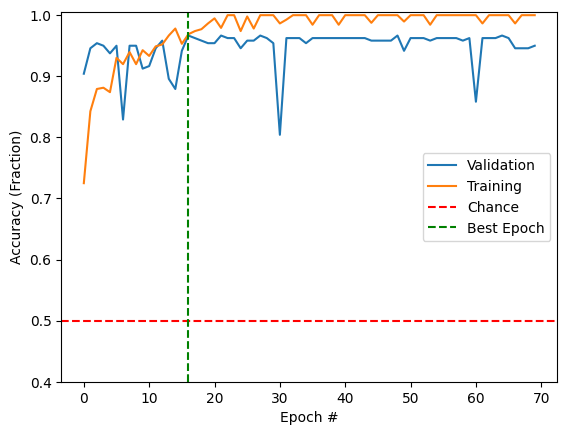

In [ ]:
model = Sequential()
model.add(Reshape((32, 32, 3))) # Try to figure out why this layer is necessary!

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

###
### WRITE YOUR CODE BELOW: Add more layers!
###
model.add(Conv2D(32,(2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))



###
### END CODE HERE
###

model.add(Flatten())
model.add(Dense(550))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Train the CNN and plot accuracy.
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=70)
plot_acc(history)


**What interesting observations** do you make from the graph? How many epochs should you train for?

We can also print out the structure of our model. What do the parts of the summary mean?

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (32, 32, 32, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (32, 32, 32, 32)       │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (32, 32, 32, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 16, 16, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (32, 15, 15, 32)       │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (32, 15, 15, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 7, 7, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 1568)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 512)              │       803,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (32, 512)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 2)                │         1,026 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (32, 2)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,618,758 (6.18 MB)

 Trainable params: 809,378 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 809,380 (3.09 MB)

## *(Optional) Reference: Understanding Hyperparameters in CNNs*




This reference section delves into the hyperparameters used in our convolutional neural networks (CNNs) and explains how adjustments to these parameters can affect model performance. Each component is exemplified by snippets from the CNN models you're working with in this notebook.

### **Core Configuration of the CNN Model**
In our first model configuration:
```python
model.add(Conv2D(96, 11, strides=3))
model.add(Activation('relu'))
...
model.add(Dense(2))
model.add(Activation('softmax'))
```
- **Number of Filters and Kernel Size**: Starting with 96 filters using an 11x11 kernel size demonstrates capturing broader features initially, which is useful for input images with higher dimensionality.
- **Strides**: Setting strides to 3 helps reduce the dimensionality of the output, speeding up computation.
- **Activation Function**: 'ReLU' is used for adding non-linearity, helping the network learn complex patterns, while 'softmax' in the output layer facilitates a probability distribution among the classes.

### **Optimizer and Learning Rate**
In the model setup, the RMSprop optimizer with a learning rate of 0.0001 is chosen:
```python
opt = keras.optimizers.RMSprop(learning_rate=0.0001)
```
- **Learning Rate**: The low learning rate allows for finer adjustments in weights, potentially leading to better convergence at the cost of requiring more epochs.

### **Advanced Model Example Using Transfer Learning**
In a different approach using the VGG16 architecture:
```python
model = VGG16(include_top=False, shape=(224, 224, 3))
for layer in model.layers:
    layer.trainable = False
...
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), ...)
```
- **Transfer Learning**: The use of VGG16, a pre-trained network, as a feature extractor (with non-trainable layers) illustrates leveraging learned features from vast datasets, which can be advantageous for specific applications.
- **SGD Optimizer**: Employing Stochastic Gradient Descent (SGD) with momentum emphasizes more robust convergence, particularly in fine-tuning scenarios.

### **Training and Validation**
Our training sessions are configured as follows:
```python
history = model.fit(...)
plot_acc(history)
```
- **Epochs and Batch Size**: Adjusting these according to the dataset size and complexity of the model influences both training speed and accuracy. Fewer epochs in the VGG16 example indicate a quicker adaptation phase due to pre-learned features.

### **Practical Tips**
- **Experiment**: Vary these hyperparameters to see their impact firsthand.
- **Balance**: Consider the trade-offs between training speed and accuracy.
- **Validation**: Always use a separate validation set to assess model generalization.

Feel free to modify these segments according to your experiment needs and observe how changes affect your model's learning curve and performance. See the next section for more concrete examples.


### (Optional) Reference: More on Hyperparameters!


Below, we explore these parameters through practical examples directly applied in Keras.

#### 1. **Number of Layers**
   - **Impact**: More layers allow a CNN to learn more complex features at different levels of abstraction. For example, deeper layers in models like VGG16 are adept at recognizing high-level features in images.
   - **Example**: `model.add(Conv2D(32, (3, 3)))` followed by multiple similar layers.

#### 2. **Number of Filters**
   - **Impact**: Each filter detects different features, and having more filters increases the network's capacity to learn diverse features.
   - **Example**: Starting with `model.add(Conv2D(32, (3, 3)))` and increasing to `model.add(Conv2D(64, (3, 3)))` in subsequent layers.

#### 3. **Filter Size**
   - **Impact**: Smaller filters (e.g., 3x3) are excellent for capturing small detail, while larger filters (e.g., 5x5) capture wider patterns.
   - **Example**: `model.add(Conv2D(64, (3, 3)))` for fine detail versus `model.add(Conv2D(64, (5, 5)))` for broader features.

#### 4. **Stride**
   - **Impact**: Strides affect how the filter moves across the image; larger strides reduce the output size.
   - **Example**: `model.add(Conv2D(64, (3, 3), strides=(2, 2)))`, reducing spatial dimensions more rapidly.

#### 5. **Padding**
   - **Impact**: 'Same' padding ensures the output has the same width and height as the input, while 'valid' does not add zero padding.
   - **Example**: `model.add(Conv2D(64, (3, 3), padding='same'))` keeps dimensions intact.

#### 6. **Activation Function**
   - **Impact**: Determines how neurons fire. Commonly used ReLU is effective for non-linear problems.
   - **Example**: `model.add(Activation('relu'))` typically follows each convolutional layer.

#### 7. **Pooling Layer**
   - **Impact**: Reduces dimensionality, thus controlling overfitting and reducing computational load.
   - **Example**: `model.add(MaxPooling2D((2, 2)))` often follows one or more convolutional layers.

#### 8. **Learning Rate**
   - **Impact**: A crucial factor in convergence speed. Too high can overshoot minimum; too low may result in a long training process.
   - **Example**: `optimizer = keras.optimizers.Adam(learning_rate=0.001)`

#### 9. **Batch Size**
   - **Impact**: Affects the memory footprint and can influence the model's generalization.
   - **Example**: `model.fit(x_train, y_train, batch_size=64)`

#### 10. **Epochs**
   - **Impact**: More epochs generally lead to a better fit, provided early stopping is used to prevent overfitting.
   - **Example**: `model.fit(x_train, y_train, epochs=20)`


---
---
# **(Optional Challenge) 🐈 Milestone 5: Cats vs. Dogs with CNN**

> Try this section out to solve a more complex problem: categorizing images as dogs or cats!



So far, we've trained a CNN to distinguish between small images of roads and small images of dogs. It's more challenging and time-consuming to train CNNs for bigger images or harder tasks, like distinguishing dogs from cats (which look a lot more like dogs than roads do!)

In this exercise, you'll adapt your previous model to classify large images of dogs vs. cats, and then try implementing a famous CNN architecture. Along the way, you'll deal with some of the debugging that machine learning engineers often have to handle.

In [ ]:
#@title Run this to load cat and dog data! {"display-mode":"form", "form-width":"25%"}

# Code here from https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb#scrollTo=4PIP1rkmeAYS

import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

try:
  road_model = model
  road_saved = True
except NameError:
  road_saved = False

IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered_extracted/cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures
train_image_generator      = ImageDataGenerator()  # Generator for our training data
validation_image_generator = ImageDataGenerator()  # Generator for our validation data
train_data = next(train_image_generator.flow_from_directory(batch_size=2000,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary'))
val_data = next(validation_image_generator.flow_from_directory(batch_size=1000,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)

                                                              class_mode='binary'))
cd_train_inputs, cd_train_labels = train_data
cd_test_inputs, cd_test_labels = val_data

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


**Run the code below to see the dimensions of our training and validation data. What does each number mean? What is different than our previous dataset?**

In [ ]:
print(cd_train_inputs.shape)
print(cd_train_labels.shape)
print(cd_test_inputs.shape)
print(cd_test_labels.shape)

(2000, 150, 150, 3)
(2000,)
(1000, 150, 150, 3)
(1000,)


**Run this code to see a random image from our training data (different each time).**

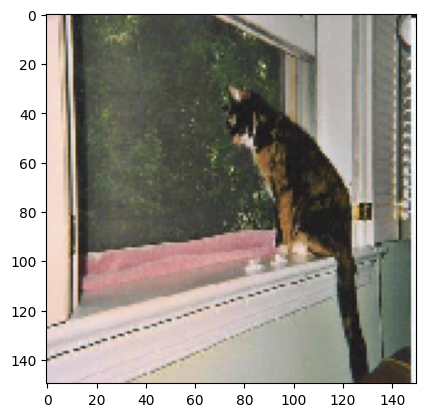

Label: 0.0


In [ ]:
index = np.random.randint(len(cd_train_inputs))
plt.imshow(cd_train_inputs[index] / 255)
plt.show()
print("Label:", cd_train_labels[index])

**By adapting code from the previous exercise, build, train, and test a CNN to classify cats vs. dogs.**
**Hints:**
*   Use `model.summary()` for a useful visualization of your model's architecture. Compare the summary of your cat/road and cat/dog classifiers.
*  Substitute the names of the new datasets.
*  Get a "first try" working by making small adjustments to a previous model before trying to optimize the accuracy. You can temporarily comment out layers as you figure things out.
*  The outputs have different shapes betweeen the two datasets. What do you need to change? (You will get a ValueError that suggests how to transform the output to a one-hot encoding. Hint: you may want to look into how to use the `to_categorical()` function)
*  If you run out of memory, restart the notebook and/or use your knowledge of convolution arithmetic to reduce the size of an intermediate output (see [Keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)).
* Dropout layers help reduce overfitting.

In [ ]:
model = Sequential()
# TODO: Your code here to build, train, and test a cats vs. dogs CNN! (If you run into errors, see the hints above for help debugging!)


## Advanced Challenge: Implementing a Famous Architecture for Cats vs. Dogs

Having trouble designing an effective architecture? Try implementing a version of AlexNet, one of the most famous CNNs for image convolution ever. You can find this image and other useful information on this network [here](https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96).

![](https://lh4.googleusercontent.com/gFAxn9Z-Y1lgkNy2GfsqjXy1DvSuYF8rvP3CslRvmuoP5SUaJMrEOr24YShU_LwalLpYNJFwpJgcDh9whk9XrMOGQ1ADQ9FY_0saicCVH0jsNPDKOYBcTG4YhbqpbPolW4hZSdUsDQ)

How do we read this diagram?

On the left side, we start with images of dimension 227x227x3 (RGB). We apply a filter composed of 96 kernels of size 11x11, with stride size 4. We end up with data of dimension 55x55x96. We pass through multiple layers of convolution and max pooling as shown, before ending with three dense (fully connected) layers.

Not shown: each layer uses ReLU activation, and we include dropout before the first two dense layers. Make sure to include those!

You'll want to adjust some of these dimensions, for a few reasons: we're starting with 150x150 rather than 227x227 images, ending with 2 labels rather than 1000, and have limited data and memory. Use your knowledge of convolution arithmetic (see CNN slides) and the [Keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) to change the stride, kernel, and/or padding.

Use `model.summary()` to understand the dimensions of your data at each step. To speed things up as you're building, you can set the number of epochs to 1.

In [ ]:
model = Sequential()
### WRITE YOUR CODE BELOW: Run, train, and test AlexNet



You might find that even AlexNet isn't working that well for you!

This is because having a good architecture is only half the battle: AlexNet is a complex model designed to learn from millions of images. We're using a small dataset of only 2000 training images, so it's not surprising that our results aren't great. Our model is overfitting: essentially memorizing the few training images, rather than really learning the difference between a cat and a dog. (The advantage is that our model trains quickly.)

To get really good performance, we need more data. If we can't find more, we could use *data augmentation*: inventing new training data by transforming our existing images. You can read more about it at https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html.

## From AlexNet to VGGNet: A Better Choice for Image Classification

AlexNet's architecture may not be complex enough to capture the nuanced differences between cats and dogs, which might result in lower accuracy in classification tasks.

VGGNet, or simply VGG, introduced by the Visual Geometry Group, is a much deeper model with its variants VGG16 and VGG19 having 16 and 19 layers respectively. VGG architecture has smaller, but more number of convolutional filters compared to AlexNet, allowing it to learn more complex features. This depth, along with the use of small 3x3 filters throughout the network, makes it excellent at learning hierarchical features in images, making it more suitable for our cat versus dog classification task.

Moreover, VGG models have been trained on millions of images from the ImageNet
database, which includes a wide variety of animal images, making the learned features more generalized and better suited for our task. Hence, moving from AlexNet to VGG for our specific classification task would be a strategic choice to potentially improve our model's performance.

So let's see how good it is at our task!

In [ ]:
#@title Run this to load images and imports! {"display-mode":"form", "form-width":"25%"}

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten


train_data = next(train_image_generator.flow_from_directory(batch_size=2000,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(224,224), #(150,150)
                                                           class_mode='binary'))
val_data = next(validation_image_generator.flow_from_directory(batch_size=1000,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(224,224), #(150,150)
                                                              class_mode='binary'))
cd_train_inputs, cd_train_labels = train_data
cd_test_inputs, cd_test_labels = val_data

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


It's crucial to note that VGG16 model requires input images to have a size of 224x224 pixels. We've already preprocessed our images to match this requirement, but ensure the model's input shape is set to this dimensionality as well!

Also, you might have noticed that there's another dimension specified in the model's input shape. Wondering what that is? It's the channel dimension. For colored images, it is usually 3, representing the Red, Green, and Blue channels.

Now, let's move onto our model configuration. For the first Dense layer, we will be using the 'relu' (Rectified Linear Unit) activation function. It's a commonly used activation function that introduces non-linearity in our model.

Following that, we'll utilize the 'sigmoid' activation function in our final Dense layer. The sigmoid function squashes the output between the range of 0 and 1, making it suitable for binary classification tasks.

In [ ]:
###
### WRITE YOUR CODE BELOW: Fill in the blanks!
###

# Load the VGG16 model without the top (classifier) layers
base_model = VGG16(include_top=False, input_shape=(______,______,______))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier on top
x = Flatten()(base_model.output)
x = Dense(128, activation='______', kernel_initializer='he_uniform')(x)
output = Dense(2, activation='______')(x)

###
### END CODE HERE
###


# Define new model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    cd_train_inputs, to_categorical(cd_train_labels),
    validation_data=(cd_test_inputs, to_categorical(cd_test_labels)),
    epochs=2
)

# Display training history and model structure
plot_acc(history)
model.summary()

NameError: name '______' is not defined

***You've reached the end!***

Moving from AlexNet to VGGNet represents a shift towards more complex and powerful models. Don't feel discouraged if it feels overwhelming - the depth and complexity of VGGNet are part of its strength and why it performs so well.

By experimenting with different hyperparameters, layers, and models you're not only enhancing your problem-solving skills but also your intuition about how neural networks operate.

Remember, even if you don't hit 95% accuracy, the key is to learn from the process and understand why a certain setup works or why it doesn't.

Keep up the fantastic work! Remember, the path to mastering machine learning is a marathon, not a sprint. Keep exploring, keep questioning, and most importantly, have fun with it!

---
---

# **🤔 Knowledge Check**

Great job getting through this notebook! If you have time, feel free to go back to the optional sections before this section to delve deeper.

Feel free to use the below questions to ensure you've learned everything from this notebook!




In [ ]:
#@markdown *1. How do we know if a model is overfitting using the training and validation curves?*
answer_1 = "" # @param {"type":"string"}

#@markdown *2. What is an activation function?*
answer_2 = "" # @param {"type":"string"}

#@markdown *3. How is a CNN different from a regular fully connected neural network?*
answer_3 = "" # @param {"type":"string"}

#@markdown *4. Categorical cross-entropy is an example of a loss function. What does a loss function do in a neural network?*
answer_4 = "" # @param {"type":"string"}

handle_discussion_response(answer_1, answer_2, answer_3, answer_4)

If you went through the optional/advanced sections, you can try these questions out too!

In [ ]:
#@markdown *1. What's the difference between the ReLU and softmax activation functions?*
answer_1 = "" # @param {"type":"string"}

#@markdown *2. Why are the results from AlexNet and VGGNet better than what we were able to build ourselves?*
answer_2 = "" # @param {"type":"string"}

handle_discussion_response(answer_1, answer_2)

---
---

# **📋 Extra Resources**

Feel free to use the following cheat sheet as a quick reference!

- [Keras Cheat Sheet](https://docs.google.com/document/d/1NK3wvy9pnpg6vab6AkdzLwGSsNf31NSIsrEYz1IVljk/edit?pli=1&tab=t.izacw33yd6ek)


The following resource should also be helpful in your understanding of CNNs:

- [CNN Explainer](https://poloclub.github.io/cnn-explainer/)